Using CUDA → NVIDIA GeForce RTX 2070 SUPER
Matched 6 patients: ['TDL010', 'TDL012', 'TDL013', 'TDL014', 'TDL015', 'TDL016']
[SeqDataset] 1396 sequences | window=77 stride=38

Inference per-patient:
Infer — TDL010 -> RMSE 0.1979 | MAE 0.1313 | R2 0.9601 | N=244


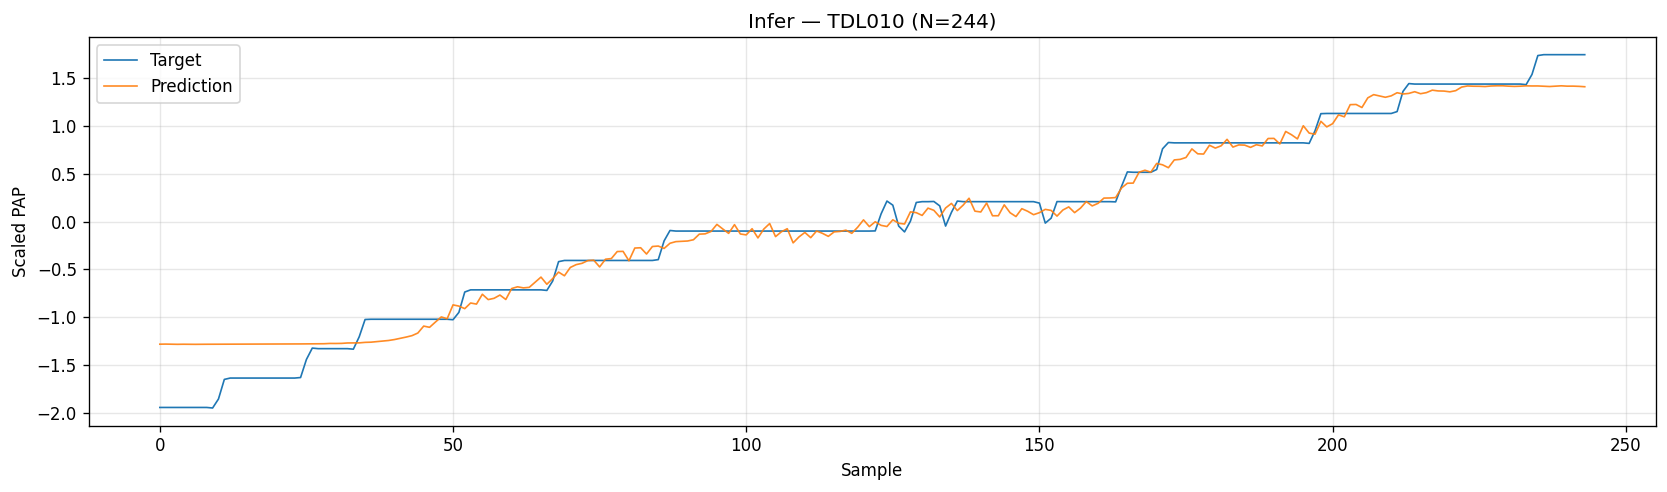

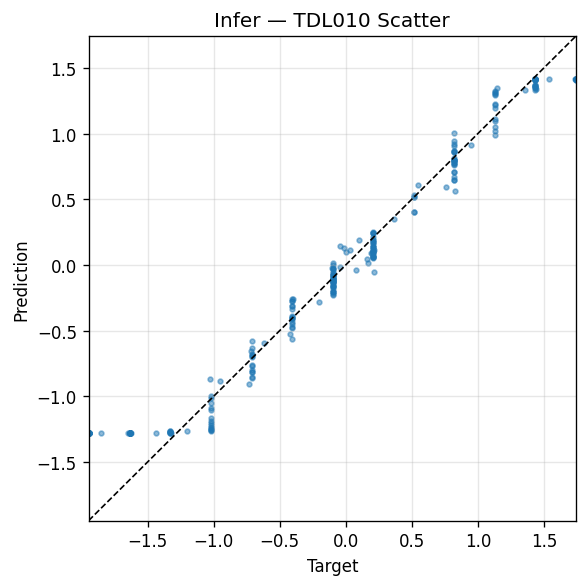

Infer — TDL012 -> RMSE 0.1261 | MAE 0.1067 | R2 0.9380 | N=237


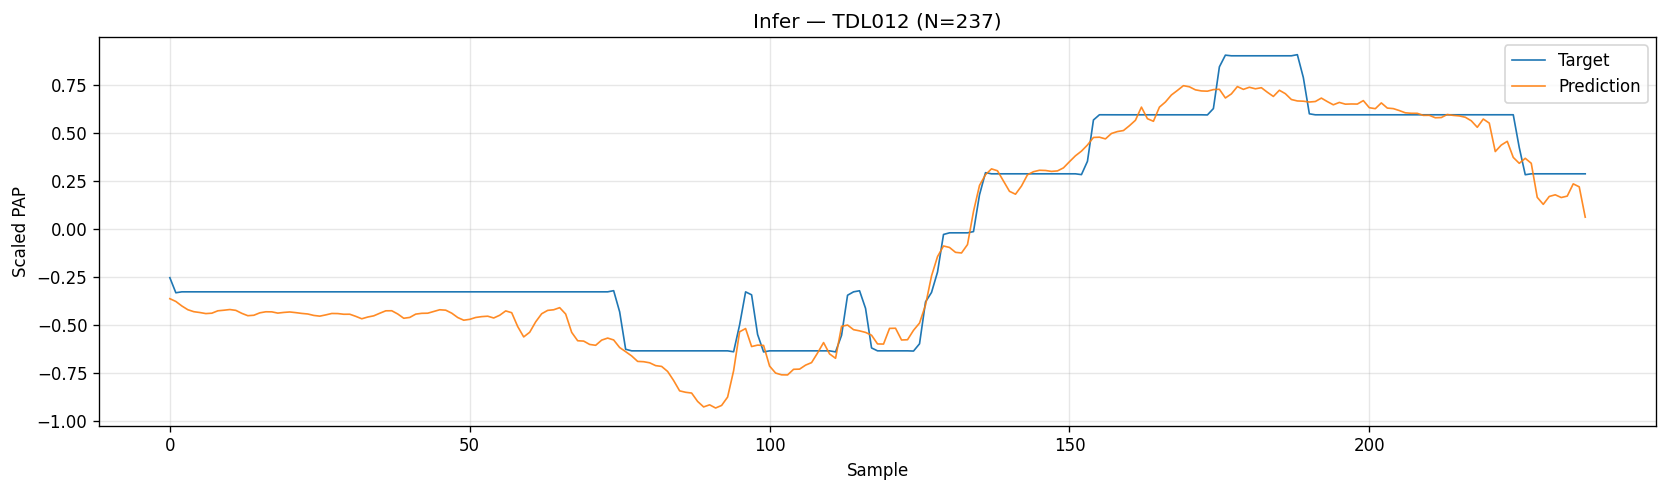

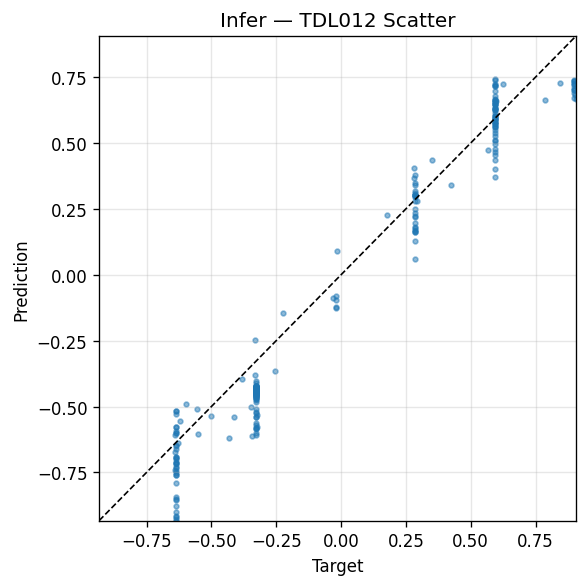

Infer — TDL013 -> RMSE 0.1709 | MAE 0.1484 | R2 0.9725 | N=244


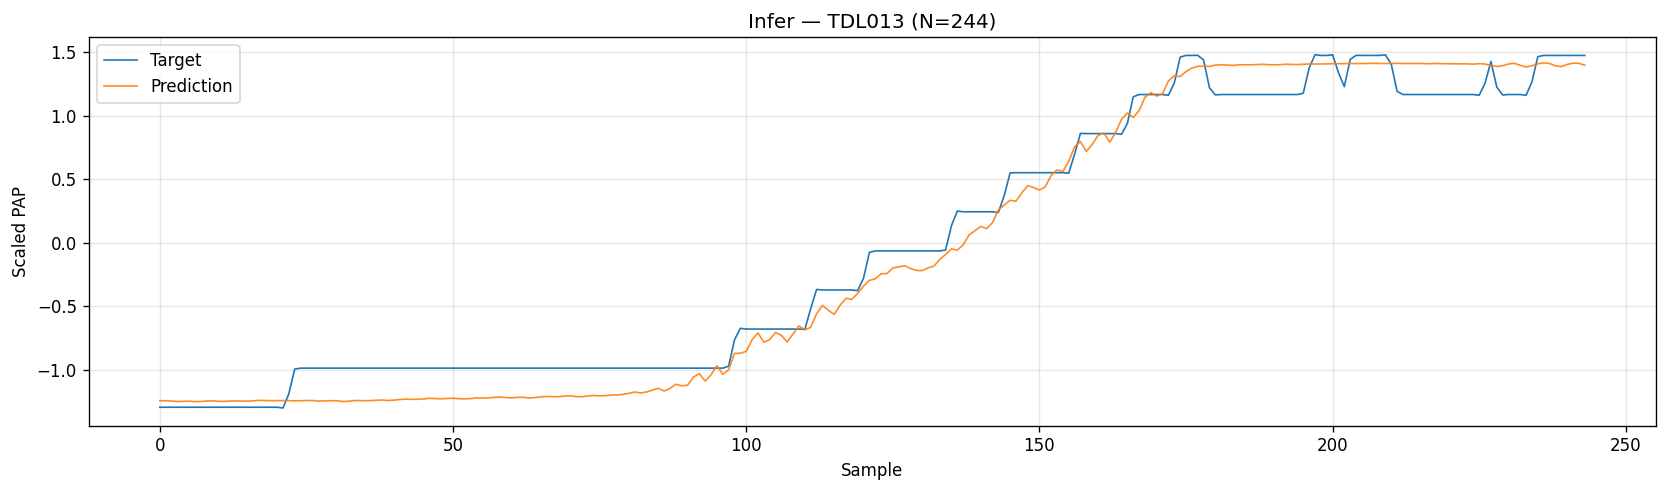

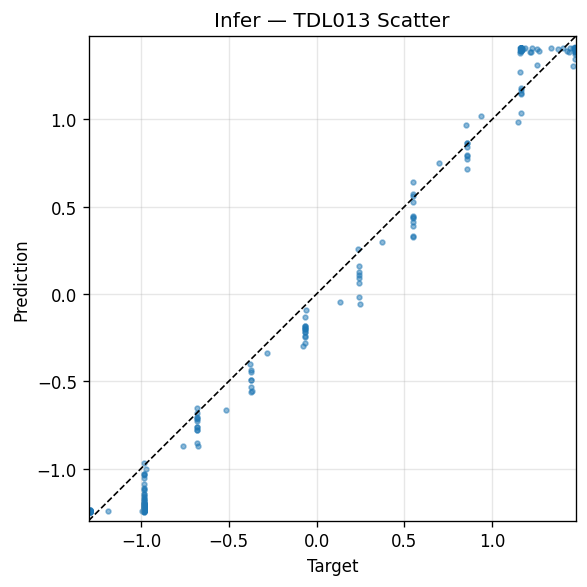

Infer — TDL014 -> RMSE 0.3736 | MAE 0.3110 | R2 0.5923 | N=237


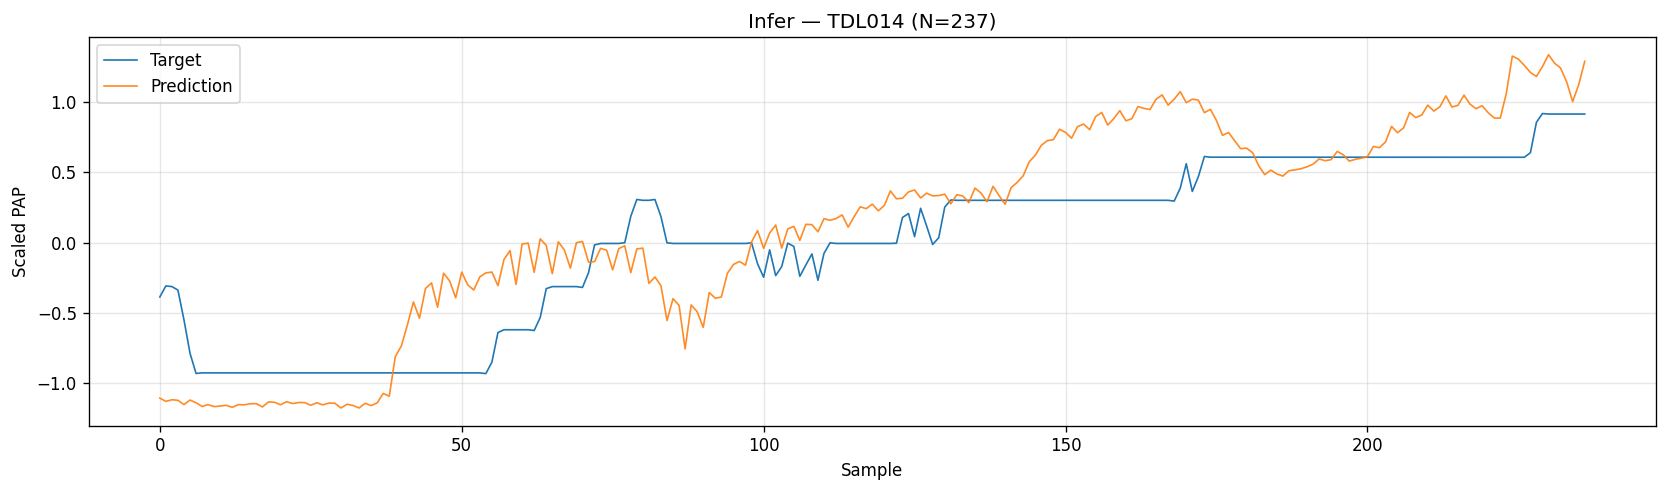

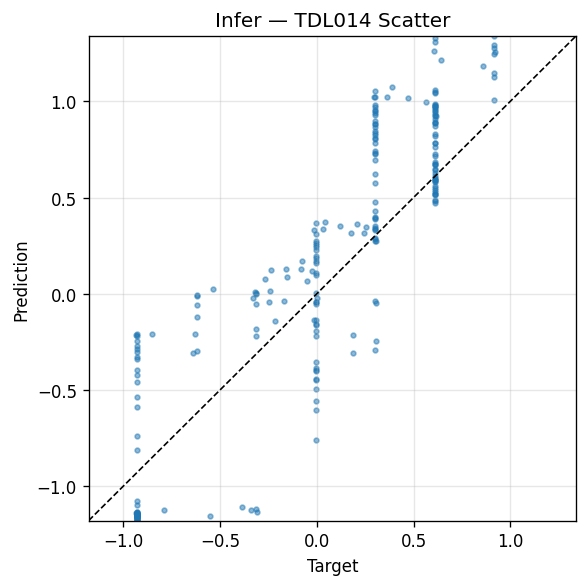

Infer — TDL015 -> RMSE 0.1340 | MAE 0.1140 | R2 0.9682 | N=197


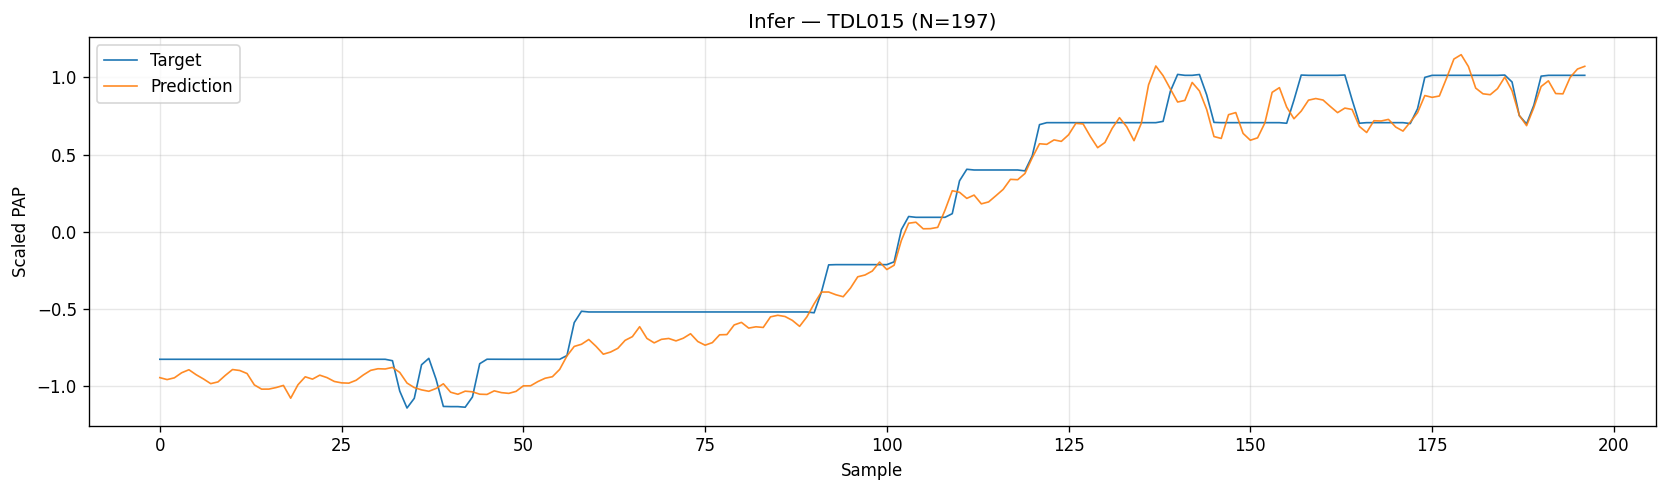

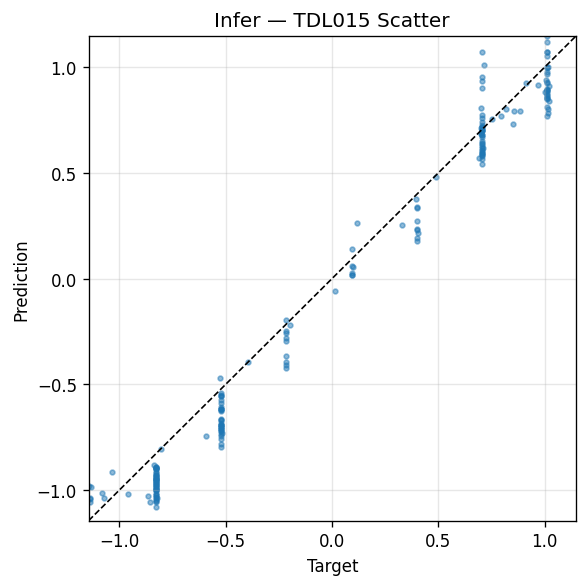

Infer — TDL016 -> RMSE 0.2549 | MAE 0.2143 | R2 0.9681 | N=237


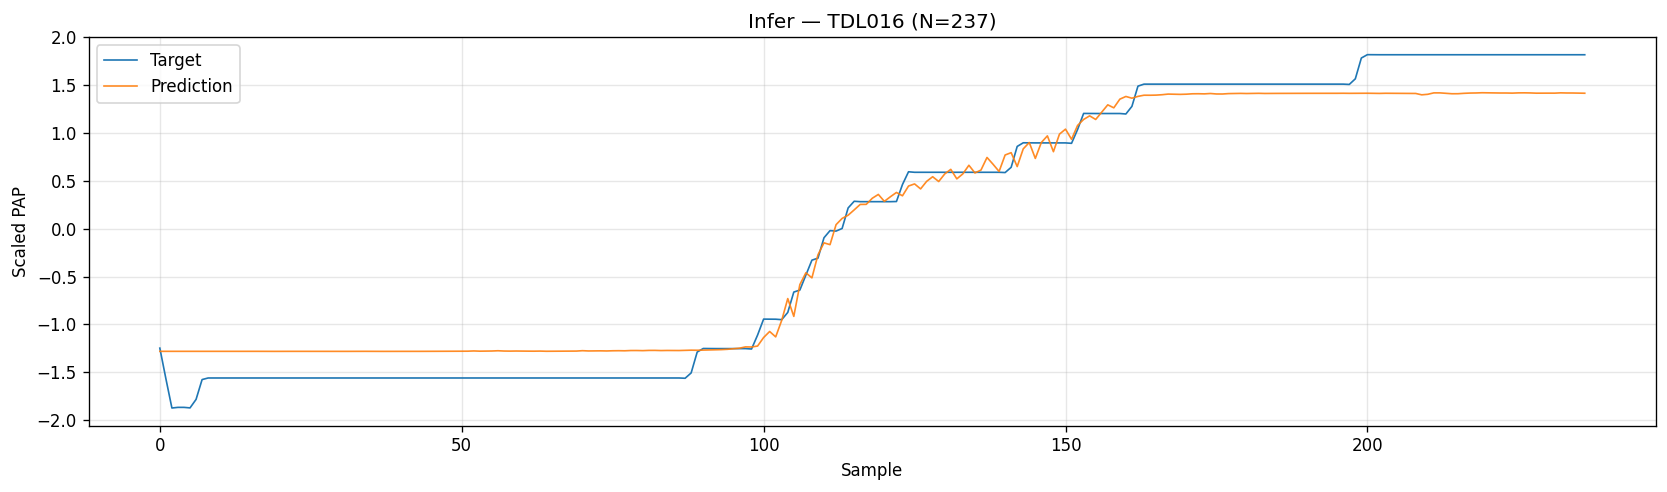

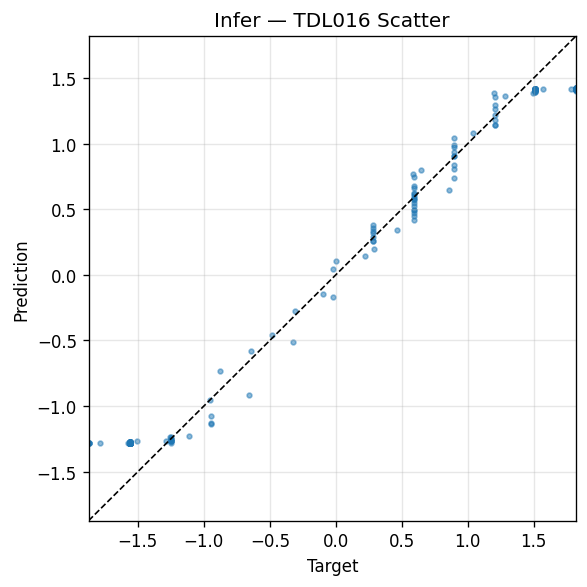

In [5]:
# =============================================================================
# MINIMAL INFERENCE — reuse SCRIPT 3.1 pipeline (no extras)
# Pass: VOLTAGE_FOLDER, PAP_FOLDER, MODEL_PATH
# =============================================================================

import os, numpy as np, pandas as pd, torch, torch.nn as nn, matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from contextlib import nullcontext
from scipy.signal import savgol_filter

# ---------------------- USER INPUTS (edit these three) -----------------------
VOLTAGE_FOLDER = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea"
PAP_FOLDER     = r"data_displaid_tidal\data_tilda_transformed\Data pap apnea upscaled"
MODEL_PATH     = r"final_stpapnet_20250909-225459.pt"   # e.g., final_stpapnet_20250905-130112.pt

# ---------------------------------------------------------------------------
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()}" + (f" → {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

# --------------------------- Helpers (same as training) ----------------------
def standardize_signal(signal: np.ndarray) -> np.ndarray:
    scaler = StandardScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

def make_trend(y: np.ndarray, win=81, poly=3) -> np.ndarray:
    win = int(win)
    if win % 2 == 0: win += 1
    if win <= poly:  win = poly + 2 + (poly % 2 == 0)
    y_med = pd.Series(y).rolling(11, center=True, min_periods=1).median().to_numpy()
    y_tr  = savgol_filter(y_med, window_length=win, polyorder=poly, mode="interp")
    return y_tr.astype(np.float32)

def _vector_to_grid(v: np.ndarray) -> np.ndarray:
    v = np.asarray(v)
    if v.shape[-1] != 208:
        raise ValueError(f"Expected 208 channels, got {v.shape[-1]}")
    return v.reshape(13, 16)

def _read_csv_basic(path: str, **kwargs) -> pd.DataFrame:
    return pd.read_csv(path, **kwargs)

def _sniff_delimiter(path: str) -> str:
    try:
        with open(path, "r", errors="ignore") as f:
            head = f.read(4096)
        commas = head.count(","); semis = head.count(";"); tabs = head.count("\t")
        if max(commas, semis, tabs) == 0: return ","
        return ";" if semis >= max(commas, tabs) else ("\t" if tabs > commas else ",")
    except Exception:
        return ","

def _to_numeric_best(s: pd.Series) -> np.ndarray:
    a = pd.to_numeric(s, errors="coerce")
    try:
        b = pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")
    except Exception:
        b = a
    a_valid = int(np.isfinite(a).sum()); b_valid = int(np.isfinite(b).sum())
    best = b if b_valid > a_valid else a
    return best.to_numpy(dtype=np.float32)

def _read_pap_csv_robust(path: str) -> pd.DataFrame:
    try:
        df = _read_csv_basic(path, sep=None, engine="python")
        if df.shape[1] >= 1: return df
    except Exception: pass
    delim = _sniff_delimiter(path)
    try:
        df = _read_csv_basic(path, sep=delim)
        if df.shape[1] >= 1: return df
    except Exception: pass
    return _read_csv_basic(path, dtype=str, sep=None, engine="python")

def _read_voltage_csv_robust(path: str) -> pd.DataFrame:
    try:
        return _read_csv_basic(path, header=None)
    except Exception: pass
    try:
        return _read_csv_basic(path, sep=None, engine="python", header=None)
    except Exception: pass
    return _read_csv_basic(path)

def _pick_pap_series(pap_df: pd.DataFrame, *, pid: str = "") -> np.ndarray:
    preferred = ["pap_on_voltage_apnea", "pap_on_eit", "pap", "perfusion", "pressure"]
    drop_like = {"time", "time_s", "t", "index", "unnamed: 0", "patientid", "id"}
    for col in pap_df.columns:
        name = str(col).lower()
        if any(k in name for k in preferred):
            s_num = _to_numeric_best(pap_df[col])
            if np.isfinite(s_num).sum() > 0:
                return s_num
    best_col, best_valid_ratio, best_series = None, -1.0, None
    for col in pap_df.columns:
        if str(col).lower() in drop_like: continue
        s_num = _to_numeric_best(pap_df[col])
        if s_num.size == 0: continue
        ratio = np.isfinite(s_num).sum() / s_num.size
        if ratio > best_valid_ratio:
            best_col, best_valid_ratio, best_series = col, ratio, s_num
    if best_series is not None and best_valid_ratio >= 0.2:
        return best_series
    raise ValueError("No suitable numeric PAP column found.")

def _canon_id_from_voltage(fname: str) -> str:
    return os.path.splitext(os.path.basename(fname))[0].replace("_voltage_apnea", "")

def _canon_id_from_pap(fname: str) -> str:
    stem = os.path.splitext(os.path.basename(fname))[0]
    for suf in ["_pap_on_voltage_apnea","_pap_on_eit","_pap_upsampled","_pap","-pap","_perfusion","-perfusion"]:
        if stem.endswith(suf): return stem[: -len(suf)]
    return stem

def _pair_voltage_pap_files(voltage_folder: str, pap_folder: str) -> List[Tuple[str, str, str]]:
    volt_map = { _canon_id_from_voltage(f): os.path.join(voltage_folder, f)
                 for f in os.listdir(voltage_folder) if f.lower().endswith(".csv") }
    pap_map  = { _canon_id_from_pap(f): os.path.join(pap_folder, f)
                 for f in os.listdir(pap_folder) if f.lower().endswith(".csv") }
    common = sorted(set(volt_map) & set(pap_map))
    return [(pid, volt_map[pid], pap_map[pid]) for pid in common]

def process_single_patient(voltage_df: pd.DataFrame, pap_df: pd.DataFrame, *, pid: str = "") -> Dict[str, np.ndarray]:
    volt_num = voltage_df.select_dtypes(include=[np.number])
    if volt_num.shape[1] < 208:
        raise ValueError(f"{pid}: voltage CSV has {volt_num.shape[1]} numeric cols; need ≥ 208.")
    V   = volt_num.iloc[:, :208].values.astype(np.float32)
    pap = _pick_pap_series(pap_df, pid=pid).astype(np.float32)
    if len(V) != len(pap):
        raise ValueError(f"{pid}: length mismatch V={len(V)} vs PAP={len(pap)}; expected pre-aligned equal length.")
    Vn   = np.apply_along_axis(standardize_signal, 0, V)
    papn = (pap - pap.mean()) / (pap.std() + 1e-8)  # not used for loss, kept for parity
    return {"voltages": V, "pap": pap, "normalized_voltages": Vn.astype(np.float32), "normalized_pap": papn.astype(np.float32)}

def load_patients_from_folders(voltage_folder: str, pap_folder: str) -> List[Tuple[str, Dict[str, np.ndarray]]]:
    patients: List[Tuple[str, Dict[str, np.ndarray]]] = []
    for pid, vpath, ppath in _pair_voltage_pap_files(voltage_folder, pap_folder):
        try:
            vdf = _read_voltage_csv_robust(vpath)
            pdf = _read_pap_csv_robust(ppath)
            if len(vdf) < 10 or len(pdf) < 2: continue
            patients.append((pid, process_single_patient(vdf, pdf, pid=pid)))
        except Exception as e:
            print(f"[WARN] {pid} skipped: {e}")
    if not patients: raise RuntimeError("No matched patients found.")
    print(f"Matched {len(patients)} patients:", [p[0] for p in patients])
    return patients

# ------------------------------ Dataset / Loader -----------------------------
class EITPAPSeqDataset(Dataset):
    def __init__(self, trend_win, patients, pid_filter, y_scaler: StandardScaler,
                 window=64, stride=8, min_len: Optional[int]=None,
                 use_normalized=True, center_per_patient=False):
        self.trend_win = int(trend_win); self.window = int(window); self.stride = int(stride)
        self.use_normalized = use_normalized; self.center_per_patient = center_per_patient; self.y_scaler = y_scaler
        self.items = []; self.data_map = {}; sel = set(pid_filter)
        for pid, d in patients:
            if pid not in sel: continue
            V = d["normalized_voltages"] if use_normalized else d["voltages"]
            y_raw = d["pap"].astype(np.float32)
            y_tr = make_trend(y_raw, win=self.trend_win, poly=3)
            if self.center_per_patient: y_tr = y_tr - float(y_tr.mean())
            yz = y_scaler.transform(y_tr.reshape(-1, 1)).ravel().astype(np.float32)
            T = len(yz); need = self.window if min_len is None else max(self.window, int(min_len))
            if T < need: continue
            self.data_map[pid] = {"V": V.astype(np.float32), "P": yz}
            for start in range(0, T - self.window + 1, self.stride):
                self.items.append((pid, start))
        print(f"[SeqDataset] {len(self.items)} sequences | window={self.window} stride={self.stride}")
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        pid, start = self.items[i]; d = self.data_map[pid]; V = d["V"]; P = d["P"]
        sl = slice(start, start + self.window); V_win = V[sl]
        X = np.stack([_vector_to_grid(v) for v in V_win], 0)  # (T,13,16)
        X = X[:, None, :, :]                                 # (T,1,13,16)
        center = start + self.window // 2
        y = P[center].astype(np.float32)
        import torch
        return torch.from_numpy(X), torch.tensor(y, dtype=torch.float32), pid, center

def build_patient_loaders(seq_ds, pid_list, batch_size=32, pin_memory=True, drop_last=False,
                          shuffle=False, balanced=False, deterministic=True, seed: int = SEED, num_workers: int = 0):
    def make_worker_init_fn(base_seed: int):
        def _fn(worker_id: int):
            import random, numpy as np, torch
            s = base_seed + worker_id
            random.seed(s); np.random.seed(s % (2**32 - 1)); torch.manual_seed(s)
        return _fn
    def make_generator(seed: int):
        import torch; g = torch.Generator(); g.manual_seed(seed); return g
    worker_init_fn = make_worker_init_fn(seed) if deterministic else None
    gen = make_generator(seed) if deterministic else None
    loaders, merged_indices = [], []
    for pid in pid_list:
        idx = [i for i, (p, _) in enumerate(seq_ds.items) if p == pid]
        if not idx: continue
        subset = Subset(seq_ds, idx)
        loaders.append(DataLoader(subset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory,
                                  drop_last=drop_last, num_workers=num_workers, worker_init_fn=worker_init_fn, generator=gen))
        merged_indices.extend(idx)
    merged_loader = None
    if merged_indices:
        merged_subset = Subset(seq_ds, merged_indices)
        merged_loader = DataLoader(merged_subset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory,
                                   drop_last=drop_last, num_workers=num_workers, worker_init_fn=worker_init_fn, generator=gen)
    return loaders, merged_loader

# --------------------------------- Model -------------------------------------
class ConvGNAct(nn.Module):
    def __init__(self, ic, oc, k=3, s=1, p=1, groups=8):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, kernel_size=k, stride=s, padding=p, bias=False)
        self.gn   = nn.GroupNorm(num_groups=min(groups, oc), num_channels=oc)
        self.act  = nn.ELU(inplace=True)
    def forward(self, x): return self.act(self.gn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv1 = ConvGNAct(c, c, 3, 1, 1)
        self.conv2 = nn.Sequential(nn.Conv2d(c, c, 3, 1, 1, bias=False), nn.GroupNorm(num_groups=min(8, c), num_channels=c))
        self.act = nn.ELU(inplace=True)
    def forward(self, x):
        y = self.conv1(x); y = self.conv2(y); return self.act(x + y)

class SpatialEncoder2D(nn.Module):
    def __init__(self, in_channels=1, base=32, dropout=0.5):
        super().__init__()
        self.stem = ConvGNAct(in_channels, base, 3, 1, 1)
        self.s1   = nn.Sequential(ResidualBlock(base), ResidualBlock(base))
        self.ds1  = ConvGNAct(base, base*2, 3, 2, 1)            # 13x16 → 7x8
        c2 = base*2
        self.s2   = nn.Sequential(ResidualBlock(c2), ResidualBlock(c2))
        self.ds2  = ConvGNAct(c2, c2*2, 3, 2, 1)                # 7x8 → 4x4
        c3 = c2*2
        self.s3   = nn.Sequential(ResidualBlock(c3), ResidualBlock(c3), ResidualBlock(c3))
        self.ds3  = ConvGNAct(c3, int(c3*1.5), 3, 2, 1)         # 4x4 → 2x2
        c4 = int(c3*1.5)
        self.s4   = nn.Sequential(ResidualBlock(c4), ResidualBlock(c4), ResidualBlock(c4))
        self.dropout = nn.Dropout(dropout)
        self.gap     = nn.AdaptiveAvgPool2d(1)
        self.proj    = nn.Linear(c4, 128)
    def forward(self, x):  # (B*T,1,13,16)
        x = self.stem(x); x = self.s1(x); x = self.ds1(x)
        x = self.s2(x);   x = self.ds2(x)
        x = self.s3(x);   x = self.ds3(x)
        x = self.s4(x)
        x = self.dropout(x); x = self.gap(x).flatten(1)
        x = self.proj(x)
        return x

class AttentionPool(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Parameter(torch.randn(d_model))
    def forward(self, X):  # (B,T,D)
        att = torch.einsum("btd,d->bt", X, self.query); w = torch.softmax(att, dim=1)
        z = torch.einsum("bt,btd->bd", w, X); return z, w

class STPAPNet(nn.Module):
    def __init__(self, in_channels=1, base=32, dropout=0.5, lstm_hidden=64, lstm_layers=2, bidirectional=True):
        super().__init__()
        self.spatial = SpatialEncoder2D(in_channels=in_channels, base=base, dropout=dropout)
        self.lstm = nn.LSTM(input_size=128, hidden_size=lstm_hidden, num_layers=lstm_layers,
                            batch_first=True, bidirectional=bidirectional, dropout=0.2)
        self.attn = AttentionPool(d_model=(2 if bidirectional else 1) * lstm_hidden)
        self.head = nn.Sequential(nn.Linear((2 if bidirectional else 1) * lstm_hidden, 128),
                                  nn.ELU(inplace=True), nn.Dropout(dropout), nn.Linear(128, 1))
    def forward(self, x):  # (B,T,1,13,16)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W); f = self.spatial(x); f = f.view(B, T, 128)
        out, _ = self.lstm(f); z, _ = self.attn(out); y = self.head(z).squeeze(-1); return y

# --------------------------- Eval (same as training) -------------------------
def epoch_pass(model, loader, optimizer=None, device=DEVICE, amp=True):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss, total_n = 0.0, 0; preds_all, tgts_all = [], []
    scaler = torch.cuda.amp.GradScaler(enabled=(amp and device == "cuda"))
    for xb, yb, _, _ in loader:
        xb = xb.to(device, non_blocking=True).float(); yb = yb.to(device, non_blocking=True).float().view(-1)
        autocast_ctx = torch.cuda.amp.autocast if (amp and device=="cuda") else nullcontext
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            with autocast_ctx(): out = model(xb).view(-1); loss = nn.functional.mse_loss(out, yb)
            scaler.scale(loss).backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
        else:
            with torch.no_grad():
                with autocast_ctx(): out = model(xb).view(-1); loss = nn.functional.mse_loss(out, yb)
        bs = xb.size(0); total_loss += loss.item() * bs; total_n += bs
        preds_all.append(out.detach().cpu().numpy()); tgts_all.append(yb.detach().cpu().numpy())
    if total_n == 0: return np.nan, np.array([]), np.array([])
    avg_loss = total_loss / total_n
    preds = np.concatenate(preds_all, axis=0); tgts = np.concatenate(tgts_all, axis=0)
    return avg_loss, preds, tgts

def compute_metrics(preds: np.ndarray, tgts: np.ndarray) -> Dict[str, float]:
    if preds.size == 0: return {"rmse": np.nan, "mae": np.nan, "r2": np.nan, "n": 0}
    mse  = float(np.mean((preds - tgts) ** 2)); rmse = float(np.sqrt(mse)); mae = float(np.mean(np.abs(preds - tgts)))
    ybar = float(np.mean(tgts)); sst = float(np.sum((tgts - ybar) ** 2)); sse = float(np.sum((preds - tgts) ** 2))
    r2   = 1.0 - (sse / sst) if sst > 0 else float("nan"); return {"rmse": rmse, "mae": mae, "r2": r2, "n": int(preds.size)}

@torch.no_grad()
def eval_per_patient(model, loaders_by_patient, device=DEVICE, title_prefix=""):
    for loader in loaders_by_patient:
        try:
            subset = loader.dataset; first_idx = subset.indices[0]; base_ds: EITPAPSeqDataset = subset.dataset
            pid = base_ds.items[first_idx][0]
        except Exception:
            pid = "unknown"
        loss, preds, tgts = epoch_pass(model, loader, optimizer=None, device=device, amp=False)
        m = compute_metrics(preds, tgts)
        print(f"{title_prefix}{pid} -> RMSE {m['rmse']:.4f} | MAE {m['mae']:.4f} | R2 {m['r2']:.4f} | N={m['n']}")
        if preds.size == 0: continue
        n = min(len(preds), len(tgts))
        plt.figure(figsize=(14,4.2), dpi=120); plt.title(f"{title_prefix}{pid} (N={n})")
        plt.plot(tgts[:n],  label="Target", linewidth=1); plt.plot(preds[:n], label="Prediction", linewidth=1, alpha=0.9)
        plt.xlabel("Sample"); plt.ylabel("Scaled PAP"); plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
        plt.figure(figsize=(5,5), dpi=120); plt.title(f"{title_prefix}{pid} Scatter")
        plt.scatter(tgts, preds, s=8, alpha=0.5)
        lo, hi = float(min(np.min(tgts), np.min(preds))), float(max(np.max(tgts), np.max(preds)))
        plt.plot([lo, hi], [lo, hi], 'k--', linewidth=1); plt.xlim(lo, hi); plt.ylim(lo, hi)
        plt.xlabel("Target"); plt.ylabel("Prediction"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ------------------------------ Load checkpoint ------------------------------
ckpt = torch.load(MODEL_PATH, map_location="cpu")
state = ckpt.get("model_state_dict", ckpt.get("model", ckpt))  # support final_*.pt or best_*.pt

# Model hyperparams as in your training main()
model = STPAPNet(in_channels=1, base=32, dropout=0.5, lstm_hidden=64, lstm_layers=2, bidirectional=True).to(DEVICE)
missing, unexpected = model.load_state_dict(state, strict=False)
if missing or unexpected:
    print(f"[warn] load_state_dict: missing={len(missing)} unexpected={len(unexpected)}")
model.eval()

# Preproc knobs (prefer those saved by your final-save block; otherwise fallbacks)
FS         = ckpt.get("fs", 50.355)
WINDOW     = int(ckpt.get("window", int(round(1.5 * FS)) | 1)) | 1
STRIDE     = int(ckpt.get("stride", max(8, WINDOW // 2)))
TREND_WIN  = int(ckpt.get("trend_win", int(round(1.5 * FS)) | 1)) | 1
CENTER_Y   = bool(ckpt.get("center_per_patient", True))
y_mean     = np.array(ckpt.get("y_scaler_mean", [0.0]), dtype=np.float32)
y_scale    = np.array(ckpt.get("y_scaler_scale", [1.0]), dtype=np.float32)

# Build a StandardScaler with saved stats (so labels match training scale)
pap_scaler = StandardScaler()
pap_scaler.mean_ = y_mean.reshape(-1)          # shape (1,)
pap_scaler.scale_ = y_scale.reshape(-1)        # shape (1,)
pap_scaler.var_ = (pap_scaler.scale_ ** 2)
pap_scaler.n_features_in_ = 1

# ------------------------------ Build data & run -----------------------------
patients = load_patients_from_folders(VOLTAGE_FOLDER, PAP_FOLDER)
all_pids = [pid for pid, _ in patients]

seq = EITPAPSeqDataset(TREND_WIN, patients, all_pids, pap_scaler,
                       window=WINDOW, stride=STRIDE, use_normalized=True,
                       center_per_patient=CENTER_Y)

loaders, _ = build_patient_loaders(seq, all_pids, batch_size=32,
                                   pin_memory=torch.cuda.is_available(),
                                   drop_last=False, shuffle=False,
                                   balanced=False, deterministic=True,
                                   seed=SEED, num_workers=0)

print("\nInference per-patient:")
eval_per_patient(model, loaders, device=DEVICE, title_prefix="Infer — ")
